In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import time

# custom libs
import sys
sys.path.append("..")
from src.simulations import simulate_curves, generate_coeffs
from src.dynamicFPC import K_dFPC, W_dFPC

In [ ]:
def print_truncated(i, step):
    if i % step == 0:
        print(f"\t {i}")

# Sample data

In [3]:
n = 100          # sample size (curves)
d = 2            # dimension parameter
nt = 256         # number of grid points
u = np.linspace(0.01, 0.99, nt)[:, None]  # nt x 1 grid
phis = generate_coeffs(d) # AR(1) model coefficients
variance = 1.5

Y, X, mEps = simulate_curves(
                        n,
                        nt,
                        u,
                        phis, 
                        variances=np.full(len(phis), variance)
                        )

In [ ]:
T, n = X.shape
x_support = np.arange(T)  

fig = go.Figure()

color_original = "#06d6a0"
color_observed = "#8338ec"

# Unobserved curves (X)
for j in range(n):
    fig.add_trace(
        go.Scatter(
            x=x_support,
            y=X[:, j],
            mode="lines",
            line=dict(color=color_original, dash="dash"),
            opacity=0.6,
            showlegend=(j == 0),
            name="Unobserved"
        )
    )

# Observed curves (Y)
for j in range(n):
    fig.add_trace(
        go.Scatter(
            x=x_support,
            y=Y[:, j],
            mode="lines",
            line=dict(color=color_observed),
            opacity=0.6,
            showlegend=(j == 0),
            name="Observed"
        )
    )

# Mean curve
fig.add_trace(
    go.Scatter(
        x=x_support,
        y=np.mean(Y, axis=1),
        mode="lines",
        line=dict(color="black", width=3),
        name="Mean(Y)"
    )
)

fig.update_layout(
    title=f"{n} Curves: Original ({color_original}) and Observed ({color_observed})",
    xaxis_title="Index",
    yaxis_title="Value",
    template="plotly_white"
)

fig.show()


# Simulations

## Estimating dimensions

In [4]:
# -----------------------
# WdFPC configuration
# -----------------------
WdFPC_kwargs = {
    "wavelet": "db2",
    "N": 3,
    "p": 5,
    "d": d,
    "nt": nt,
}

# -----------------------
# KdFPC configuration
# -----------------------
KdFPC_kwargs = {
    "lag_max": 5,
    "alpha": 0.10,
    "du": 0.05,
    "B": 1000,
    "p": 5,
    "m": nt,
    "u": u,
    "select_ncomp": False,
    "dimension": d,
}

In [ ]:
# Repetitions
R = 10_000

# Variable
D = 10

timings = {}
for d in range(1, D+1):
    print(f">>>Initiating simulations for d={d}")
    wd_times = np.zeros(R)
    kd_times = np.zeros(R)  
    phis = generate_coeffs(d)

    for r in range(R):
        print_truncated(r,200)
        
        Y, X, mEps = simulate_curves(
                                n,
                                nt,
                                u,
                                phis, 
                                variances=np.full(len(phis), variance)
                                )

        # ---- WdFPC timing ----
        t0 = time.perf_counter()

        WdFPC_model = W_dFPC(Y)
        WdFPC_kwargs["d"] = d
        WdFPC_model.fit(**WdFPC_kwargs)

        wd_times[r] = time.perf_counter() - t0

        # ---- KdFPC timing ----
        t0 = time.perf_counter()

        KdFPC_model = K_dFPC(Y)
        KdFPC_kwargs["dimension"] = d
        KdFPC_model.fit(**KdFPC_kwargs)

        kd_times[r] = time.perf_counter() - t0

    df_timing = pd.DataFrame({"W": wd_times, "K": kd_times})
    timings[d] = df_timing

In [32]:
df = pd.DataFrame()

for k in timings.keys():
    df0 = timings[k]
    df0["r"] = k
    df = pd.concat([df, df0], axis=0)

In [39]:
df.columns = ["WdFPC", "KdFPC", "d"]

In [46]:
print(f"Median of {R:,} simulations for estimating each d of {D} dimensions for {n} curves")
df.groupby("d").median()

Median of 10,000 simulations for estimating each d of 10 dimensions for 100 curves


,WdFPC,KdFPC
d,,
1,0.063722,0.004133
2,0.063787,0.003703
3,0.063029,0.004528
4,0.059256,0.003807
5,0.060620,0.004483
6,0.060661,0.004542
7,0.055070,0.003470
8,0.060443,0.004564
9,0.059066,0.004598


In [35]:
df.to_excel("../data/processed/time_simulation_dim.xlsx", index=False)

## Changing number of curves

In [ ]:
# Repetitions
R = 10

# Variable
N = [100, 500, 1_000, 10_000]


D = 4
phis = generate_coeffs(d)
timings_n = {}
for n in N:
    print(f">>>Initiating simulations for n={n}")
    wd_times = np.zeros(R)
    kd_times = np.zeros(R)  
    
    for r in range(R):
        print_truncated(r,2)
        
        Y, X, mEps = simulate_curves(
                                n,
                                nt,
                                u,
                                phis, 
                                variances=np.full(len(phis), variance)
                                )

        # ---- WdFPC timing ----
        t0 = time.perf_counter()

        WdFPC_model = W_dFPC(Y)
        WdFPC_kwargs["d"] = D
        WdFPC_model.fit(**WdFPC_kwargs)

        wd_times[r] = time.perf_counter() - t0

        # ---- KdFPC timing ----
        t0 = time.perf_counter()

        KdFPC_model = K_dFPC(Y)
        KdFPC_kwargs["dimension"] = D
        KdFPC_model.fit(**KdFPC_kwargs)

        kd_times[r] = time.perf_counter() - t0

    df_timing = pd.DataFrame({"W": wd_times, "K": kd_times})
    timings_n[n] = df_timing

In [14]:
df = pd.DataFrame()

for k in timings_n.keys():
    df0 = timings_n[k]
    df0["r"] = k
    df = pd.concat([df, df0], axis=0)

In [16]:
df.columns = ["WdFPC", "KdFPC", "n"]
print(f"Median of {R:,} simulations for estimating n of {N} curves with dimension {4}")
df.groupby("n").median()

Median of 10 simulations for estimating n of [100, 500, 1000, 10000] curves with dimension 4


,WdFPC,KdFPC
n,,
100,0.057987,0.003343
500,0.072716,0.184935
1000,0.113491,0.708298
10000,4.839057,308.740094


In [17]:
df.to_excel("../data/processed/time_simulation_n.xlsx", index=False)

In [24]:
df_long = df.melt(
    id_vars="n",
    value_vars=["WdFPC", "KdFPC"],
    var_name="Method",
    value_name="Time"
)

# make sure n is categorical
df_long["n"] = df_long["n"].astype(str)

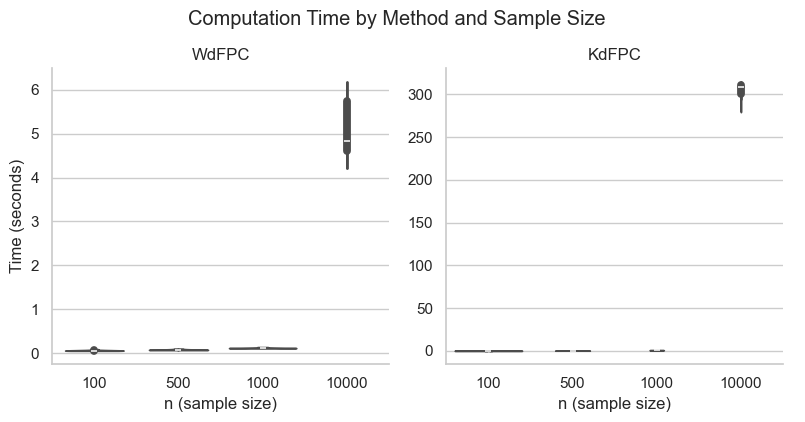

In [26]:
sns.set(style="whitegrid")

g = sns.catplot(
    data=df_long,
    x="n",
    y="Time",
    col="Method",
    kind="violin",
    inner="box",
    cut=0,
    sharey=False,
    height=4,
    aspect=1
)

g.set_axis_labels("n (sample size)", "Time (seconds)")
g.set_titles("{col_name}")
g.fig.suptitle("Computation Time by Method and Sample Size", y=1.05)

plt.show()